# Presentation

#### Goal: Predict the number of nights granted to a request (not to an individual)


#### Caracteristics of the model:
Accuracy:
- if used as a clearing tool removing overburden upfront, and thus only to get rid of obvious cases, the accuracy of such a tool could be its most important caracteristic.

Interpretability:
- could help families understand the decision (although not as important as in diseases predictions).
- can also highlight and thus control biases (racial, sex, age).
- since the tool would probably be used in combination with human selection, it could help save time by highlighting the main factors for each decision

#### Conclusion:
- a model easily interpretable could be prefered (tree).
- or a highly accurate model (less interpretable) could also be used upfront (NN).


#### Future improvements

Imputations:
- Build more robust, generalisable imputations (eg. impute future test samples with missing gender based on all easily interpretable categories group_composition_label and group_composition_id)

- Automate NaNs imputation for future test samples

- Reconstruct some NaNs by training models to predict the feature


Datasets handling
- I made the choice to keep the train and test sets split. This is to prevent gaining insight from the test set while doing pre-processing, analysis and while training the model. To prevent duplicate code, I thus placed most of the inner workings in the class Analysis, which makes the reading less fluent. To improve, see how to better combine the visual aspect of Jupyter Notebooks, while maintaining code standards like DRY philosophy.


Pre-processing
- impact historical data with the known global crises (financial crisis, immigration waves)

# Plan

I. Initialization

1. Import packages, classes, functions

2. Load databases (no join)

3. Instanciate object Analysis


II. Analyze I

1. Overview

2. Features: corr, dist, impact


III. Pre-process data

1. Impute NaNs

2. Impute never seen before test set NaNs

3. Remove outliers

4. Transform categorical features

5. Feature engineer



IV. Analyze II

1. Impact engineered features


V. Build Model

1. Benchmakrs

2. Rush pytorch NN

3. Simple model using principal components

4. Ensemble


VI. Predictions

1. Train and Predict

2. Hyperparameter tunning (split train set)


VII. Evaluate methods


# Initialization

## Import packages, classes, functions

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML
from sklearn.metrics import log_loss
from sklearn import tree

# DL
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear
from torch import nn, optim

# Utils
import cobratools as cobra

In [2]:
# Define the test scorer
def competition_scorer(y_true, y_pred, weights):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)

In [3]:
# set to False to only apply data transformations
# (rather than derive the whole analysis)
ANALYZE_ON = True

# False for the competition, True if predicting > year 2019 requests
FUTURE_PRED = False

# Takes ±4min
IMPUTE_NANS = True

# Set to True to visualize
PRINT_ON = True  # verbose
PLOT_ON = True

## Load data

In [4]:
requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

## Join datasets

Since there are multiple requests by individuals and multiple individuals by request, the straightfoward approach would be to create columns for each individual' informations. This way, no information would be lost, but the curse of dimensionality is very near and the number of samples might be too low to extract useful information.

The chosen approach is rather to only keep the request dataset' columns, and feature engineer additional columns based on the individuals data, eg.:
- nb of past requests made by the same individual
- nb nights granted in past requests of the same individual(s)/group
- gender diversity of the group
- etc.

However, for analytics purpose, a dataframe with all the data is also created.

In [5]:
if ANALYZE_ON:
    # Merge request and individuals datasets, for analytics purpose only
    df_full_train = pd.merge(requests_train, individuals_train, on='request_id')

In [6]:
# Set index col as request id
# (not for individuals data set, since there is no pkey currently)
# (hence not for obj_full_train either)
requests_train.set_index('request_id', inplace=True)
requests_test.set_index('request_id', inplace=True)

## Instanciate object analysis

obj_train and obj_test will be the main dataframes, used for training and testing the model

They are primilary built with the request data sets, then features engineered from individuals' data sets are added

In [7]:
# Instanciate analysis object with request data
obj_train = cobra.Analysis(requests_train)
obj_test = cobra.Analysis(requests_test)
obj_full_train = cobra.Analysis(df_full_train)

# Define properties

# - target
target = 'granted_number_of_nights' 
obj_train.target = target
obj_full_train.target = target

# - shape
obj_train.m = obj_train.df.shape[0]
obj_test.m = obj_test.df.shape[0]
obj_train.n = obj_train.df.shape[1]
obj_test.n = obj_test.df.shape[1]
obj_full_train.m = df_full_train.df.shape[0]
obj_full_train.n = df_full_train.df.shape[1]

# Analysis I

Overview

- Number of requests: 238191

- Number of individuals: 384133

- Number of features: 39

- Requests are made for 1.6 pers on average.


Principal components
- housing_situation_label: with value "emergency accomodation". High probability to get 1 or two nights. Logical since the service treats emergency housing
- housing_situation_2_label: with value "emergency accomodation". High probability to get 1 or two nights.

--------------------


Analysis by features


A. housing_situation_id
- correlation target-housing_situation_id: -0.458581. Strong negative impact. Although the linear numerical relation of the housing_situation_id categories is in my opinion flawed, the strong correlation is explainable as the category with the smallest value "emergency accomodation" might be correlated with higher granted_number_of_nights than the rest of the categories, which happen to have higher housing_situation_id values.

- housing_situation_2_id: 0.283840. Strong positive impact. Same explanation as housing_situation_id.

B. pregnancy
- Pregnancy seems not to have a significant direct correlation with target

## Overview

In [ ]:
if ANALYZE_ON:
    obj_train.describe(investigation_level=3)

In [ ]:
if ANALYZE_ON:
    obj_train.visualize()

## Analysis by features

### housing_situation_2_label

- ±42% (160,061) indiv with 'housing_situation_label' == 'street'

- ±41% (156,496) indiv with 'housing_situation_label' == 'street' and 'housing_situation_2_label' == 'on the street'

- ±75% (289,870) individuals are "on the street"

- A majority of requests with the label "emergency accomodation" obtains 1 or 2 nights.

#### Distribution

In [10]:
if ANALYZE_ON:
    # ±42% (160,061) indiv with 'housing_situation_label' == 'street'
    obj_full_train.df[obj_full_train.df['housing_situation_label'] == 'street']

    # ±41% (156,496) indiv with 'housing_situation_label' == 'street' and 'housing_situation_2_label' == 'on the street'
    obj_full_train.df.query("housing_situation_label == 'street' and housing_situation_2_label == 'on the street'")

    # ±75% (289,870) individuals are "on the street"
    print(obj_full_train.df['housing_situation_2_label'].value_counts())

on the street                                      289870
hotel paid by the emergency structure               39716
emergency accomodation                              14872
day center, social services, associations           14479
accomodated by friends or other                      6694
other                                                6449
reception center for asylum seeker                   2599
public instition (hospital, retirement home)         2413
accomodated by family                                1602
hotel not paid by an emergency structure             1332
winter plan center                                    953
private housing rental                                494
emergency accomodation centre for asylum seeker       437
public housing rental                                 365
residential roaming                                   280
child care                                            271
medical centre                                        243
emergency cent

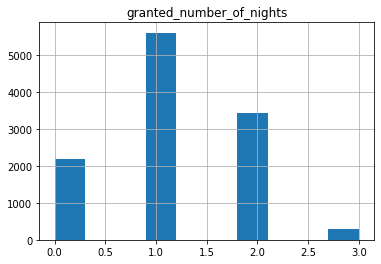

In [15]:
if ANALYZE_ON:
    # Obs: A majority of requests with the label "emergency accomodation" obtains 1 or 2 nights.

    # Impact of feature on target
    feature = 'housing_situation_2_label'
    mask = obj_full_train.df[feature] == 'emergency accomodation'

    # Hist: drop duplicate requests (due to indiv data merged)
    obj_full_train.df[mask][['request_id', target]].drop_duplicates().hist()
    plt.show()

### child_situation

In [16]:
# debug
obj_train.df.columns

Index(['animal_presence', 'answer_creation_date', 'child_situation',
       'child_to_come', 'district', 'granted_number_of_nights',
       'group_composition_id', 'group_composition_label',
       'group_creation_date', 'group_id', 'group_main_requester_id',
       'group_type', 'housing_situation_id', 'housing_situation_label',
       'long_term_housing_request', 'number_of_underage',
       'request_backoffice_creator_id', 'request_creation_date',
       'requester_type', 'social_situation_id', 'town', 'victim_of_violence',
       'victim_of_violence_type'],
      dtype='object')

In [ ]:
if ANALYZE_ON:
    # Impact on target
    feature = 'child_situation'
    

### animal_presence

In [ ]:
if ANALYZE_ON:
    feature = 'animal_presence'
    mask = df_train[feature] == 't'
    df_train[mask][[feature, target]]

### requester_type along with group_main_requester_id
if it is an urgentist, used to bring individuals to the service, its groups might have higher granted rates

In [ ]:
# TODO: check

### request_backoffice_creator_id
this might impact since each people has its own biases (as for the predictions of court decisions)

In [ ]:
# TODO: check

# Pre-process data

Methodology:

- Clean-up request dataset

- Feature engineer using indiv dataset

## Impute NaNs

Methodology:
- inspect NaNs on train set

- if pattern detected, apply modifications on train and test sets

Observations:
- reverse engineering: the system seems to derive group_composition_id from group_composition_label, and both are then necessary linked/redondant => drop group_composition_label

- there can be multiple individuals by request, and multiple requests by individual

Further:
- Impute 14 pregnancy NaNs from child_to_come (not useful for the current objective)

### NaNs train summary

In [ ]:
if ANALYZE_ON:
    # Get Na counts: by feature, by sample
    na_ft_train, na_sp_train = obj_train.get_na_counts()
    na_ft_test, na_sp_test = obj_test.get_na_counts()
    if PRINT_ON:
        print('Train: NaNs count by feature\n\n', na_ft_train[na_ft_train!=0])
        #print('\n\nTest: NaNs count by feature\n\n', na_ft_test[na_ft_test!=0])

### Impute child_to_come NaNs

Observation
- There are 145947 NaNs for child_to_come on the train set (in request)

- There are only 14 NaNs for pregnancy in train set (in individuals)

Hypotheses
- Hyp: child_to_come is True if any indiv of the group is pregnant

Conclusion
- => Impute child_to_come from the pregnancy in the group of indiv of the request

Control
- Verify that the imputation is not only setting to 'f':
- -> successful: from the 145947 requests, 5375 are set to 't'


In [ ]:
if ANALYZE_ON:
    # Capture the indexes where NaNs
    df_train_raw_nas = obj_train.df[obj_train.df['child_to_come'].isna()]
    idx_nas = df_train_raw_nas['child_to_come'].index

In [7]:
if IMPUTE_NANS:
    # TODO: refactor (this takes ±3min)
    # Impute train set
    obj_train.impute_child_to_come(df_indiv=individuals_train)
    # Impute test set
    obj_test.impute_child_to_come(df_indiv=individuals_test)

In [ ]:
if ANALYZE_ON:
    # Get number of NaNs imputed as False and True
    obj_train.df.loc[idx_nas]['child_to_come'].value_counts()

### Impute housing_situation_label

The following code cells are organized as follows for clarity:
- Imputation steps

- Analysis

Observations

A. Meta numbers
- ±7% (16,748) NaNs for housing_situation_label (request)

- 0 NaN for housing_situation_id (request)

- 0 NaN for housing_situation_label_2 (individuals)

- 0 NaN for housing_situation_id_2 (individuals)

- 21 housing_situation_label (request)

- 22 housing_situation_id (request)

B. Specific ratios
- ±10% (23,309) indiv with NaN at 'housing_situation_label'

- ±90% (21,185) of missing housing_situation_label are housing_situation_2_label "on the street" 

C. Analysis 1
- housing_situation_id is derived from housing_situation_label

- housing_sitaution_label NaNs have their specific id: 170

- => there are actually 16748 NaNs for housing_situation_id (request)

D. Analysis 2
- housing_situation_2_label can be very diverse when housing_situation_label is NaN (17 over 21 cat)

- => housing_situation_label NaNs are not produced in a specific housing_situation_2_label situation

E. Analysis 3
- all individuals of a same request share the same housing_situation_2_label

- => NaNs do not come from a problem of aggregating indiv data

Hypotheses
- Hyp: the housing situation should logically have an impact on the result

- Hyp: proba being on the street is significantly high to always impute NaN with 'street'

- Hyp: housing_ids are not sorted in any specific order from which a logic could be derived. Thus, having numerical ids is dangereous and could lead to misinterpretations by the model.

Conclusion
- => Impute housing_situation_label NaNs as 'street'

- => Drop housing_situation_id

- => one-hot encode housing_situation_label


Further improvements
- derive more sub-groups: when a group is not housing_situation_label_2 'on the street', impute the request housing_situation_label with its most often matched value

#### Impute NaNs with the single value 'street'

In [8]:
if IMPUTE_NANS:
    # Impute housing_situation_label NaNs as 'street'
    obj_train.df.loc[obj_train.df['housing_situation_label'].isna(), 'housing_situation_label'] = 'street'
    obj_test.df.loc[obj_test.df['housing_situation_label'].isna(), 'housing_situation_label'] = 'street'

    # Drop housing_situation_id
    obj_train.df.drop('housing_situation_id', axis=1, inplace=True)
    obj_test.df.drop('housing_situation_id', axis=1, inplace=True)

    # One-hot encoding is applied later-on

#### Get the mapping of housing_situation_id - housing_situation_label
- housing_situation_id is derived from housing_situation_label

- housing_sitaution_label NaNs have their specific id: 170

- => there are actually 16748 NaNs for housing_situation_id (request)


In [ ]:
if ANALYZE_ON:
    # Get mapping housing_situation_id - housing_situation_label
    map_housing_id_label = obj_train.df.loc[:, ['housing_situation_id', 'housing_situation_label']].drop_duplicates()

    # Sort and drop index for clarity
    map_housing_id_label = map_housing_id_label.sort_values(by='housing_situation_id')
    map_housing_id_label.reset_index(drop=True, inplace=True)
    map_housing_id_label

#### Analyze relation between housing_situation_label (request) and housing_situation_2_label (indiv)

Make a temporary dataframe with columns:

| request_id | gr_nb_nights | hous_id | hous_lab | indiv_id | hous_2id | hous2_lab

In [ ]:
if ANALYZE_ON:
    # request [gr_nb_nights, hous_id, hous_lab]
    rq = obj_train.df.loc[:, ['granted_number_of_nights', 'housing_situation_id', 'housing_situation_label']]

    # individuals [request_id, indiv_id, hous_2id, hous2_lab]
    ind = individuals_train.loc[:, ['request_id', 'individual_id', 'housing_situation_2_id', 'housing_situation_2_label']]
    ind.set_index('request_id', inplace=True)

    # Merge request and individuals datasets
    obj_full_train = pd.merge(rq, ind, on='request_id')

Study figures

In [ ]:
if ANALYZE_ON:
    # Nb of indivs (an indiv is considered a new indiv at each request)
    nb_indivs = obj_full_train.shape[0]

    # ±6% (23,309) indiv with NaN at 'housing_situation_label'
    obj_full_train[obj_full_train['housing_situation_label'].isna()]

    # ±90% (21,185) of missing housing_situation_label are housing_situation_2_label "on the street" 
    df_temp = obj_full_train[obj_full_train["housing_situation_label"].isna()]
    df_temp['housing_situation_2_label'].value_counts()

Inspect individuals with housing_situation_2_label "on the street":

- they can have a very diverse housing_situation (17 categories over a total of 21)

- => no pattern to derive from this point of view

In [ ]:
if ANALYZE_ON:
    q = obj_full_train.query("housing_situation_label.isna() and housing_situation_2_label != 'on the street'")

    # Count number of categories for housing_situation_2_label
    n_cat_2 = len(q.loc[:, 'housing_situation_2_label'].unique())

    # Total categories for the feature
    n_cat_1 = len(obj_train.get_col_uniques('housing_situation_label'))

Check if housing_situation_label NA exist when indiv within a group have different housing_situation_2

- no divergence

- => when group, all indiv have the same housing_situation_2_label

In [ ]:
if ANALYZE_ON:
    # takes ±1min
    if False:
        # Get request_id along with its group size
        rq_id = obj_full_train.index.value_counts()
        for i in range(70000):
            # Get ith rq_id
            rq_id_i = rq_id.index[0]

            # Observe if housing_situation_label same for all the group members
            n_uni_grp = len(obj_full_train.loc[rq_id_i]['housing_situation_label'].unique())
            n_uni_indiv = len(obj_full_train.loc[rq_id_i]['housing_situation_2_label'].unique())

            if n_uni_grp > 1 or n_uni_indiv > 1:
                print(i)
                print(n_uni_grp, n_uni_indiv)
                print("\n")

#### Further improvements: derive the most probable mapping

In [ ]:
if ANALYZE_ON:
    # Get mapping housing_situation_label - housing_situation_2_label
    obj_full_train_no_na = obj_full_train[~obj_full_train.housing_situation_label.isna()]
    map_housing_labels = obj_full_train_no_na.loc[:, ['housing_situation_label', 'housing_situation_2_label']].drop_duplicates()

    # Sort and drop index
    map_housing_labels = map_housing_labels.sort_values(by='housing_situation_label')
    map_housing_labels.reset_index(drop=True, inplace=True)
    map_housing_labels

### Impute long_term_housing_request NaNs

Nb NaNs: 165556

In [ ]:
# TODO

### Impute town NaNs

Nb NaNs: 159959

In [ ]:
# TODO

### Impute victim_of_violence_type NaNs

Nb NaNs: 234175

is NaN if victim_of_violence is 'f'


=> Replace these NaNs by say 0

In [ ]:
# TODO

### Temporarily drop columns with NaNs remaining
(untill imputation methods are implemented)

In [9]:
# TODO: impute properly
list_drop = [
    'long_term_housing_request',
    'town',
    'victim_of_violence_type'
]
for col in list_drop:
    obj_train.df.drop(col, axis=1, inplace=True)
    obj_test.df.drop(col, axis=1, inplace=True)

### Temporarily drop numerical columns
(that can't be used properly untill transformation methods are implemented)

In [10]:
# TODO: transform rather than drop
list_drop = [
    'child_situation',
    'district',
    'group_composition_id',
    'group_id',
    'group_main_requester_id',
    'request_backoffice_creator_id',
    'social_situation_id'
]

for feature in list_drop:
    obj_train.df.drop(feature, axis=1, inplace=True)
    obj_test.df.drop(feature, axis=1, inplace=True)

## Impute remaining test set NaNs
(that have no equivalent in train set, and thus can't be studied to build a clever imputation method)

In [11]:
# TODO: implement method based on train set logic for any feature
obj_train.set_default_na_vals()

# Transfer default NaNs to test object
obj_test.default_na_vals = obj_train.default_na_vals

# Impute any remaining NaN based on its default value
obj_test.impute_nans()

## Outliers

### Drop answer creation date
hyp: the variable is not available at prediction time

In [ ]:
# For the purpose of the competition, is it expected to be used?
if FUTURE_PRED:
    obj_train.df.drop('answer_creation_date', axis=1, inplace=True)
    obj_test.df.drop('answer_creation_date', axis=1, inplace=True)

### Delete old samples
(if it was to predict future requests (> 2020))
- Train/test split being done randomly (≠ historically), it is important for this competition to train the model on the whole train set (don't remove old samples)
- Delete samples with group_creation_date < 2015, since it is very unlikely that current demands are treated like +5 years ago (social services evolve)
- Threshold date: see if later is better, potential gains from domain knowledge

In [ ]:
if FUTURE_PRED:
    # Drop samples with year < 2015
    old_samples = obj_train.df[obj_train.df.group_creation_date.dt.year < 2015]
    obj_train.df.drop(old_samples.index, axis=0, inplace=True)

### Gender

- => Only females are possibly pregnant, thus 30 males have made a mistake

In [ ]:
# TODO: Retrieve the individual ids, and correct for male -> pregnancy = 0
#obj_train.df['gender'].groupby(obj_train.df['pregnancy']).value_counts()

## Feature Engineering


### Clusterize large categorical features

In [ ]:
# TODO: make clusters then transform using one-hot encoding

### Transform dates
- into linear numerical features (year, month)

- and into categorical features (hot_season, col_season:T/F)

#### Features: Dates to year, month

In [12]:
# List of columns of date type
list_date_cols = [
    'request_creation_date',
    'group_creation_date'
]

# Don't use the feature if trying to build robust in-production model
if not FUTURE_PRED:
    list_date_cols.append('answer_creation_date')

# Transform date type: string to timestamp
for col in list_date_cols:
    obj_train.df[col] = pd.to_datetime(obj_train.df[col])
    obj_test.df[col] = pd.to_datetime(obj_test.df[col])

# Create feature: 'year'
for col in list_date_cols:
    obj_train.df[col[:-4]+'year'] = obj_train.df[col].dt.year
    obj_test.df[col[:-4]+'year'] = obj_test.df[col].dt.year

# Create feature: 'month'
for col in list_date_cols:
    obj_train.df[col[:-4]+'month'] = obj_train.df[col].dt.month
    obj_test.df[col[:-4]+'month'] = obj_test.df[col].dt.month

# Drop raw features of type date
for col in list_date_cols:
    obj_train.df.drop(col, axis=1, inplace=True)
    obj_test.df.drop(col, axis=1, inplace=True)

#### New Feats: hot_season, col_season

In [ ]:
# TODO
hot_months = [7, 8]
col_months = [1, 1, 11, 12]

### Transform Town to regions

In [ ]:
# TODO

### New Feat: nb of indivs in the group

In [ ]:
# TODO

### New Feat: nb of past requests by indivs forming the group of the request

In [ ]:
# TODO

# Single individual

# Get number of ALL requests of indiv with max n_requests
#ind_id = obj_full_train['individual_id'].value_counts().index[0]

# Watch request made by the same indiv
#obj_full_train[obj_full_train['individual_id'] == ind_id]

# TODO: Past requests only

### New Feat: nb of past granted request by indivs forming the group

In [ ]:
# TODO

## Transform categorical features
Prepare data to feed models

- booleans: replace by (1, 0)

- 2 < cats < 11: one-hot encoding

- No transform on features with more than 11 categories

In [ ]:
if ANALYZE_ON:
    # Display col name along its type
    for col, col_type in zip(obj_train.df.columns, obj_train.get_cols_type()):
        print(col_type, col)

### Transform all categorical features

In [13]:
# Pre-process columns:
# - booleans: 't', 't' => True, False
# - Categorical with few classes => one-hot encoding
bools_train, failed_train = obj_train.transform_categories(target=obj_train.target)
bools_test, failed_test = obj_test.transform_categories(target=obj_test.target)

# Preprocess specific cat columns
obj_train.convert_to_bool(col='group_type',
                            true_val='group',
                            false_val='individual')

# Preprocess specific cat columns
obj_test.convert_to_bool(col='group_type',
                            true_val='group',
                            false_val='individual')

# Export data
#obj_train.export_data('data/data_train_preprocessed.csv')
#obj_test.export_data('data/data_test_preprocessed.csv')

Transform Boolean at col animal_presence: True/False=['f' 't']
Transform Boolean at col child_to_come: True/False=[False  True]

ERROR - Transform Boolean at col group_type not recognized: ['individual' 'group']

Transform Boolean at col victim_of_violence: True/False=['f' 't']
Transform Boolean at col animal_presence: True/False=['f' 't']
Transform Boolean at col child_to_come: True/False=[False  True]

ERROR - Transform Boolean at col group_type not recognized: ['group' 'individual']

Transform Boolean at col victim_of_violence: True/False=['f' 't']

ERROR - Transform Boolean at col answer_creation_year not recognized: [2019 2018]



(('group', 'individual'), False)

# Analysis II
(df_train)

Analysis focused on impact of one-hot encoded variables and new engineered features

In [ ]:
# TODO

### Dates
Link btw group_creation_date and request_creation_date


In [ ]:
# TODO
#pd.DataFrame([rq_crea_dt_seconds, grp_crea_dt_seconds]).corr()

# Predict

## Build models

### Benchmark

In [14]:
# Random uniform train/test
random_preds_train = np.random.uniform(size=(requests_train.shape[0], 4))
random_preds_test = np.random.uniform(size=(requests_test.shape[0], 4))

### Prepare data sets

In [715]:
#obj_test.df.drop(['request_creation_year', 'group_creation_year', 'answer_creation_year'], axis=1, inplace=True)

In [718]:
# Set train/cross-validation split
TRAIN_VAL_SPLIT = 0.8
n_train_samples = round(obj_test.df.shape[0] * TRAIN_VAL_SPLIT)

# Mask - all features columns but target
ma_feats = obj_train.df.columns != target

# Split train and cross-val sets && features (X) vs target (Y)
X_train = obj_train.df.iloc[n_train_samples:, ma_feats]
X_val = obj_train.df.iloc[:n_train_samples, ma_feats]
Y_train = obj_train.df[target][n_train_samples:]
Y_val = obj_train.df[target][:n_train_samples]

# Transform sets to torch tensors
X_train = torch.from_numpy(X_train.values)
X_val = torch.from_numpy(X_val.values)
Y_train = torch.from_numpy(Y_train.values)
Y_val = torch.from_numpy(Y_val.values)

# Split X-Y and transform to tensors
X_test = torch.from_numpy(obj_test.df.loc[:, ma_feats].values)
Y_test = torch.from_numpy(obj_test.df[target].values)

# Cast to float type
X_train = X_train.float()
X_val = X_val.float()
Y_train = Y_train.float()
Y_val = Y_val.float()
X_test = X_test.float()
Y_test = Y_test.float()

In [719]:
# Instanciate datasets
#dataset_train = cobra.Dataset(X=X_train, Y=Y_train)
#dataset_val = cobra.Dataset(X=X_val, Y=Y_val)
#dataset_test = cobra.Dataset(X=X_test, Y=Y_test)
dataset_train = Dataset(X=X_train, Y=Y_train)
dataset_val = Dataset(X=X_val, Y=Y_val)
dataset_test = Dataset(X=X_test, Y=Y_test)


# Instanciate data loaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = dataset_train.len)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = dataset_val.len)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = dataset_test.len)

# Set log-loss criterion
#y_vals = [0, 1, 2, 3]
#weights = [10**y for y in y_vals]
#weights = [.2, .25, .27, .3]
#class_weights = torch.FloatTensor(weights)
criterion = nn.CrossEntropyLoss() #weight=class_weights)

In [720]:
# Reinitialize model and weights
layers = [obj_train.df.columns.size-1, 100, 48, 60, 4]
#model = cobra.NN(layers)
model = NN(layers, p=0.2)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

# Reset loss history
loss_epochs = {
    'train': [],
    'eval': []
    }
loss_epochs_compet = {
    'train': [],
    'eval': []
    }

In [726]:
# Train model
n_epochs = 10

# Loop over epochs
for epoch in range(n_epochs):

    # Lists batchs loss
    loss_batchs = {
        'train': [],
        'eval': []
        }
    loss_batchs_compet = {
        'train': [],
        'eval': []
    }

    # Training
    # --------
    for n_batch, (x, labels) in enumerate(dataloader_train):

        # Predict
        predictions = model(x)

        # Evaluate
        loss = criterion(predictions, labels).mean()
        loss_compet = competition_scorer(labels.numpy(), predictions.detach().numpy().clip(.025, .95))

        # Compute gradients
        optimizer.zero_grad()
        loss.backward()

        # Backpropagate
        optimizer.step()

        # Add batch loss to the list of current epoch
        loss_batchs['train'].append(round(loss.item(), 4))
        loss_batchs_compet['train'].append(round(loss_compet, 4))

        #print('epoch {}, batch {}, loss {}'.format(epoch, n_batch, round(loss.item(), 4)))
        #print('           compet loss {}\n'.format(round(loss_compet, 4)))


    # Validation
    # ----------
    for n_batch, (x, labels) in enumerate(dataloader_val):
        # Predict on the eval set
        predictions = model(x)
        
        # Compute batch loss
        loss = criterion(predictions, labels).mean()
        loss_compet = competition_scorer(labels.numpy(), predictions.detach().numpy().clip(.025, .95))
        
        # Add batch loss to the list of current epoch
        loss_batchs['eval'].append(round(loss.item(), 4))
        loss_batchs_compet['eval'].append(round(loss_compet, 4))


    # Compute train and eval losses for the epoch, and add to epochs list
    for set_name in ['train', 'eval']:
        loss_epoch = torch.tensor(loss_batchs[set_name], dtype=float).mean()
        loss_epoch_compet = pd.DataFrame(loss_batchs_compet[set_name]).mean()[0]
        loss_epochs[set_name].append(round(loss_epoch.item(), 4))
        loss_epochs_compet[set_name].append(round(loss_epoch_compet, 4))


    print(f"Avg epoch {epoch}")
    print(f"  loss train: {loss_epochs['train'][-1]} - eval: {loss_epochs['eval'][-1]}")
    print(f"compet train: {loss_epochs_compet['train'][-1]} - eval: {loss_epochs_compet['eval'][-1]}\n")

Avg epoch 0
  loss train: 1.2863 - eval: 1.2685
compet train: 1.3967 - eval: 1.367

Avg epoch 1
  loss train: 1.2712 - eval: 1.2545
compet train: 1.3758 - eval: 1.3472

Avg epoch 2
  loss train: 1.2574 - eval: 1.2416
compet train: 1.3575 - eval: 1.333

Avg epoch 3
  loss train: 1.2443 - eval: 1.2295
compet train: 1.3423 - eval: 1.3218

Avg epoch 4
  loss train: 1.2319 - eval: 1.2182
compet train: 1.3302 - eval: 1.3133

Avg epoch 5
  loss train: 1.2202 - eval: 1.208
compet train: 1.3227 - eval: 1.3074

Avg epoch 6
  loss train: 1.2097 - eval: 1.1983
compet train: 1.3141 - eval: 1.3004

Avg epoch 7
  loss train: 1.1998 - eval: 1.1893
compet train: 1.3071 - eval: 1.2969

Avg epoch 8
  loss train: 1.1904 - eval: 1.1805
compet train: 1.3025 - eval: 1.2934

Avg epoch 9
  loss train: 1.1814 - eval: 1.1723
compet train: 1.2998 - eval: 1.2849



In [694]:
class NN(nn.Module):
    def __init__(self, layers, p=0):
        super(NN, self).__init__()
        self.hidden_layers = nn.ModuleList()

        # Set seed to reproduce results
        torch.manual_seed(1000)
        
        for input_size, output_size in zip(layers, layers[1:]):
            self.hidden_layers.append(nn.Linear(input_size, output_size))
            #self.hidden_layers.append(nn.Dropout(p=p))
            self.hidden_layers.append(nn.BatchNorm1d(output_size))

    def forward(self, activation):
        for i_layer, linear_transform in enumerate(self.hidden_layers):
            if i_layer < len(self.hidden_layers) - 1:
                activation = torch.relu(linear_transform(activation))
            else:
                activation = linear_transform(activation)
        return activation

In [723]:
l_pred = predictions.detach().numpy() #.argmax(axis=1)
if True:
    l_pred = predictions.detach().numpy() #.argmax(axis=1)
    target = labels.numpy()
    sum(l_pred == y)/len(target)

a = pd.DataFrame({'A':target})
l = pd.DataFrame({'L':l_pred.argmax(axis=1)})
#print('\nvalues used for predictions:',*l.drop_duplicates()['L'].sort_values())
print(l_pred)
#print(l)
print('\nPredictions:')
print(l['L'].value_counts())
print('\ntarget:')
print(a['A'].value_counts())

sum(l['L'] == target)/len(target)

/Users/Pro/shortcuts/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


TypeError: 'bool' object is not iterable

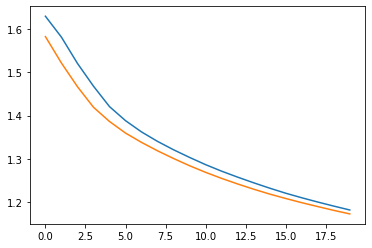

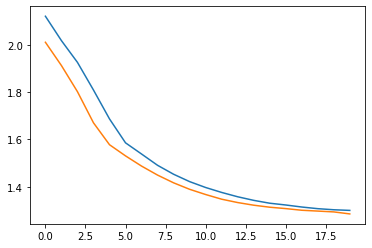

In [727]:
n_skip = 0
plt.plot(loss_epochs['train'][n_skip:])
plt.plot(loss_epochs['eval'][n_skip:])
plt.show()
plt.plot(loss_epochs_compet['train'][n_skip:])
plt.plot(loss_epochs_compet['eval'][n_skip:])
plt.show()

In [708]:
# Lists batchs loss
loss_batchs = {
    'test': []
    }

# Test set
# --------
for n_batch, (x, labels) in enumerate(dataloader_test):
    # Predict on the test set
    predictions = model(x)
    
    # Compute batch loss
    loss = criterion(predictions, labels)
    loss_compet = competition_scorer(labels.numpy(), predictions.detach().numpy().clip(.0025, .95))
    
    # Add batch loss to the list of current epoch
    loss_batchs['test'].append(round(loss.item(), 4))

# Compute train and test losses for the epoch, and add to epochs list
loss_test = torch.tensor(loss_batchs['test'], dtype=float).mean()
loss_test = round(loss_test.item(), 4)

print(f"Avg loss test: {loss_test}\n")
print(f"compet loss: {loss_compet}")

Avg loss test: 1.1559

compet loss: 1.5950991248107869


In [656]:
# Verify matching btwn compet_scorer and criterion
# NO MATCH !!
if False:
    y_vals = [0, 1, 2, 3]
    weights = [10**y for y in y_vals]
    class_weights = torch.FloatTensor(weights)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion_loss = criterion(predictions, labels)
    print(criterion_loss)

if True:
    # Define the test scorer
    def competition_scorer(y_true, y_pred):
        return log_loss(y_true, y_pred) #, sample_weight=10**y_true)
    #compet_loss = competition_scorer(labels.numpy(), predictions.detach().numpy())
    #print(compet_loss)


In [340]:
y_vals = [0, 1, 2, 3]
weights = [10**y for y in y_vals]
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)  # 10**y_true

# Set log-loss criterion
#weights = [0.00001+ 1/10**y for y in y_vals]
#class_weights = torch.FloatTensor(weights)
criterion = nn.CrossEntropyLoss() #weight=class_weights, reduction='none')

def cross_entropy(predictions, targets):
    N = predictions.shape[0]
    ce = -np.sum(targets * np.log(predictions)) / N
    return ce

predictions = np.array([[0.25,0.25,0.25,0.25],
                        [0.01,0.01,0.01,0.97]])
targets = np.array([[1,0,0,0],
                   [0,0,0,1]])

target_compet = np.array([0, 3])

predictions_t = torch.from_numpy(predictions).float()
targets_t = torch.from_numpy(np.array([0, 3]))

print(cross_entropy(predictions, targets))
print(competition_scorer(target_compet, predictions))
print(criterion(predictions_t, targets_t))

0.7083767843022996


ValueError: y_true and y_pred contain different number of classes 2, 4. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 3]

### Univariate predictions

We observed a significant (negative) correlation of housing_situation_id with granted_number_of_nights, let's train a univariate model


In [ ]:
# Set model' parameters
clf = tree.DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    max_leaf_nodes=None,
    class_weight=None)

# Build train/test datasets with housing_situation_id only
X_train = np.array(requests_train['housing_situation_id']).reshape(-1, 1)
X_test = np.array(requests_test['housing_situation_id'].values).reshape(-1, 1)
Y_train = requests_train.granted_number_of_nights.values
Y_test = requests_test.granted_number_of_nights.values

# Transform categorical target into a one-hot vector
Y_train_onehot = to_onehot(Y_train)
Y_test_onehot = to_onehot(Y_test)

# Train the model
clf = clf.fit(X_train, Y_train_onehot)

# Yield train/test predictions
preds_train_tree_univar = clf.predict(X_train)
preds_test_tree_univar = clf.predict(X_test)

# Fill predictions to .2 elsewhere
preds_train_tree_univar[preds_train_tree_univar == 0] = .2
preds_test_tree_univar[preds_test_tree_univar == 0] = .2

# Evaluate train/test
score_train = competition_scorer(Y_train, preds_train_tree_univar)
score_test = competition_scorer(Y_test, preds_test_tree_univar)

# Display results
print(f'train score: {score_train:.2f}')
print(f'test score: {score_test:.2f}')

In [ ]:
probas = clf.predict_proba(X_train)
v0 = probas[0].max(1)
v1 = probas[1].max(1)
v2 = probas[2].max(1)
v3 = probas[3].max(1)

## Evaluate models

In [ ]:
y_true_test = requests_test.granted_number_of_nights.values

# Evaluate benchmarks
random_score_test = competition_scorer(y_true_test, random_preds_test)
dumb_score_test = competition_scorer(y_true_test, dumb_preds_test)

# Display results
print(f'test score random: {random_score_test:.2f}')
print(f'test score dumb: {dumb_score_test:.2f}')

### Train set

In [ ]:
y_true_train = requests_train.granted_number_of_nights.values

# Evaluate benchmarks
random_score_train = competition_scorer(y_true_train, random_preds_train)
dumb_score_train = competition_scorer(y_true_train, dumb_preds_train)

# Display results
print(f'train score random: {random_score_train:.2f}')
print(f'train score dumb: {dumb_score_train:.2f}')

### Test set

## Interpret models

In [ ]:
# Tree
fn = ['housing_situation_id']
cn = ['0', '1', '2', '3']

tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True)

requests_train['housing_situation_id'].hist()